In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        
   
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("thickness")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Negative current collector thickness [m]	2.5e-05
Negative electrode thickness [m]	6.2e-05
Positive current collector thickness [m]	2.5e-05
Positive electrode thickness [m]	6.7e-05
Separator thickness [m]	1.2e-05


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
#         "calculate discharge energy":"true"
    }
)

In [5]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
    "Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
       "Nominal cell capacity [A.h]":2.5,
        "Maximum concentration in positive electrode [mol.m-3]":37500,
        
        "Positive electrode thickness [m]":5.45e-05,

        
        
    }
)
cell = 152002

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp=45

In [7]:
#experimets
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")


# drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_default_5Ah.csv", comment="#", header=None).to_numpy()
# drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_default_5A_norgen10_min.csv", comment="#", header=None).to_numpy()

# drive_cycle2 = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_GM_5Ah.csv", comment="#", header=None).to_numpy()
# drive_cycle_OEM1 = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_GM_2_5Ah_norgen10_min.csv", comment="#", header=None).to_numpy()
# Created_Drive = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\Created_Drive_2_5Ah.csv", comment="#", header=None).to_numpy()
Half_Creeted_Drive = pd.read_csv("/Users/hamid/Drive Cycle/Halfhourdrive2p5Ah.csv", comment="#", header=None).to_numpy()


# experiment3 = pybamm.Experiment( #GM_ DRC-DRC
#     [
#         ("Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for .6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#           "Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*10,
#     drive_cycles={"US06_OEM1": drive_cycle_OEM1},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment4 = pybamm.Experiment( #Gm-RCRC
#     [
#         ("Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run US06_OEM1 (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 3.1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*1000,
#     drive_cycles={"US06_OEM1": drive_cycle_OEM1},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment13 = pybamm.Experiment( #Created_ DRC-DRC
#     [
#         ("Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for .7 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 1.1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*10,
#     drive_cycles={"Creeted_Drive": Created_Drive},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment14 = pybamm.Experiment( #Creeted-RCRC
#     [
#         ("Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.2V",
#          "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.2V",
#           "Hold at 4.2V for 3.2 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*10,
#     drive_cycles={"Creeted_Drive": Created_Drive},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )



# experiment23 = pybamm.Experiment( #Created_ DRC-DRC  # Charging to 4.0 V to check for dissol
#     [
#         ("Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.0V",
#          "Hold at 4.0V for .7 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Discharge at C/4 for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.0V",
#           "Hold at 4.0V for 1.1 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*10,
#     drive_cycles={"Creeted_Drive": Created_Drive},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

# experiment24 = pybamm.Experiment( #Creeted-RCRC
#     [
#         ("Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/4 until 4.0V",
#          "Hold at 4.0V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
#          "Rest for 20 minutes", 
#          # Home
#          "Run Creeted_Drive (A) for 1 hours",
#          "Rest for 5 minutes",
#          "Rest for 1 hours", # should be P/4 
#          "Rest for 5 minutes",
#          "Charge at C/8 until 4.0V",
#           "Hold at 4.0V for 3.2 hours",  # needs fixing : last step +this step =4.5 hrs
#          "Rest for 20 minutes",     
#         )

#     ]*10,
#     drive_cycles={"Creeted_Drive": Created_Drive},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )


experiment33 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment34 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
# LOWER voltages
experiment133 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.9V",
         "Hold at 3.9V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.9V",
          "Hold at 3.9V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment134 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.9V",
         "Hold at 3.9V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.9V",
          "Hold at 3.9V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)


experiment233 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.75V",
         "Hold at 3.75V for 1.5 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.75V",
          "Hold at 3.75V for 2.1 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)

experiment234 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 3.75V",
         "Hold at 3.75V for 2.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 3.75V",
          "Hold at 3.75V for 3.9 hours",  # needs fixing : last step +this step =4.5 hrs
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="65% capacity",
#     cccv_handling="ode",
)


In [9]:
K_SEI_list=[4.20e-16  , 4.35e-16]
D_SEI_list=[6.66e-19  , 3.69e-19]
k_pl_list=[4.54e-10   , 4.64e-10]
k_diss_list=[0        , 6.24e-04]
b_LAM_p_list=[10.06e-8, 7.65e-08]
b_LAM_n_list=[8.73e-8 , 8.76e-08]
Ea_SEI_list=[6026     , 5997.629]
# March17(no diss)    , March23(diss)
list_num=1

# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": b_LAM_p_list[list_num], #10.0638e-08, #8.3747149e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":b_LAM_n_list[list_num],#8.7257e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]":K_SEI_list[list_num],# 4.1964e-16,# 4.17385539e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": D_SEI_list[list_num], #6.6582e-19, #1.79830186e-18, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]":Ea_SEI_list[list_num],#6.02602e+03, # 6.18700763e+03, #1.87422275e+04,1.58777981e+04,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]":  30000.0,# 1.3e06,
        "Lithium plating kinetic rate constant [m.s-1]":k_pl_list[list_num],#4.543e-10, # 4.50936e-10
        
        
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density": k_diss_list[list_num],
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.0,
        
    },
    check_already_exists=False,
)

In [10]:
SOC_0=0.55
all_sumvars_dict234 = cycle_adaptive_simulation(spm, parameter_values, experiment234, SOC_0,save_at_cycles=1, drive_cycle=Half_Creeted_Drive)


2023-08-03 23:56:54.841 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (14.406 ms elapsed) --------------------
2023-08-03 23:56:54.842 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
CasADi - 2023-08-03 23:56:54 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]
2023-08-03 23:56:55.193 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/14: Rest for 5 minutes
2023-08-03 23:56:55.268 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/14: Rest for 1 

2023-08-03 23:57:09.513 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (15.020 us elapsed) --------------------
2023-08-03 23:57:09.513 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-08-03 23:57:09.853 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/14: Rest for 5 minutes
2023-08-03 23:57:09.864 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/14: Rest for 1 hours
2023-08-03 23:57:09.935 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/14: Rest for 5 minutes
2023-08-03 23:57:09.941 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 5/14: Charge at C/4 until 3.75V
2023-08-03 23:57:10.013 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 6/14: Hold at 3.75V for 2.6 hours
2023-08-03 23:57:10.495 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 7/14: Rest for 20 minutes
2023-08-03 23:57:10.529 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 8/14: Run Half_Creeted_

2023-08-03 23:57:23.966 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 5/14: Charge at C/4 until 3.75V
2023-08-03 23:57:24.022 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 6/14: Hold at 3.75V for 2.6 hours
2023-08-03 23:57:24.515 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 7/14: Rest for 20 minutes
2023-08-03 23:57:24.543 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-08-03 23:57:24.804 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 9/14: Rest for 5 minutes
2023-08-03 23:57:24.815 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 10/14: Rest for 1 hours
2023-08-03 23:57:24.878 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 11/14: Rest for 5 minutes
2023-08-03 23:57:24.885 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 12/14: Charge at C/8 until 3.75V
2023-08-03 23:57:24.973 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 13/14: Hold at 3.75V for

2023-08-03 23:57:38.884 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 10/14: Rest for 1 hours
2023-08-03 23:57:38.950 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 11/14: Rest for 5 minutes
2023-08-03 23:57:38.959 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 12/14: Charge at C/8 until 3.75V
2023-08-03 23:57:39.047 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 13/14: Hold at 3.75V for 3.9 hours
2023-08-03 23:57:39.755 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 14/14: Rest for 20 minutes
2023-08-03 23:57:40.063 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 1.682 Ah (originally 1.682 Ah, will stop at 1.093 Ah)
2023-08-03 23:57:40.063 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 2.473 s
2023-08-03 23:57:41.107 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (14.526 us elapsed) --------------------
2023-08-03 23:57:41.108 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/14: 

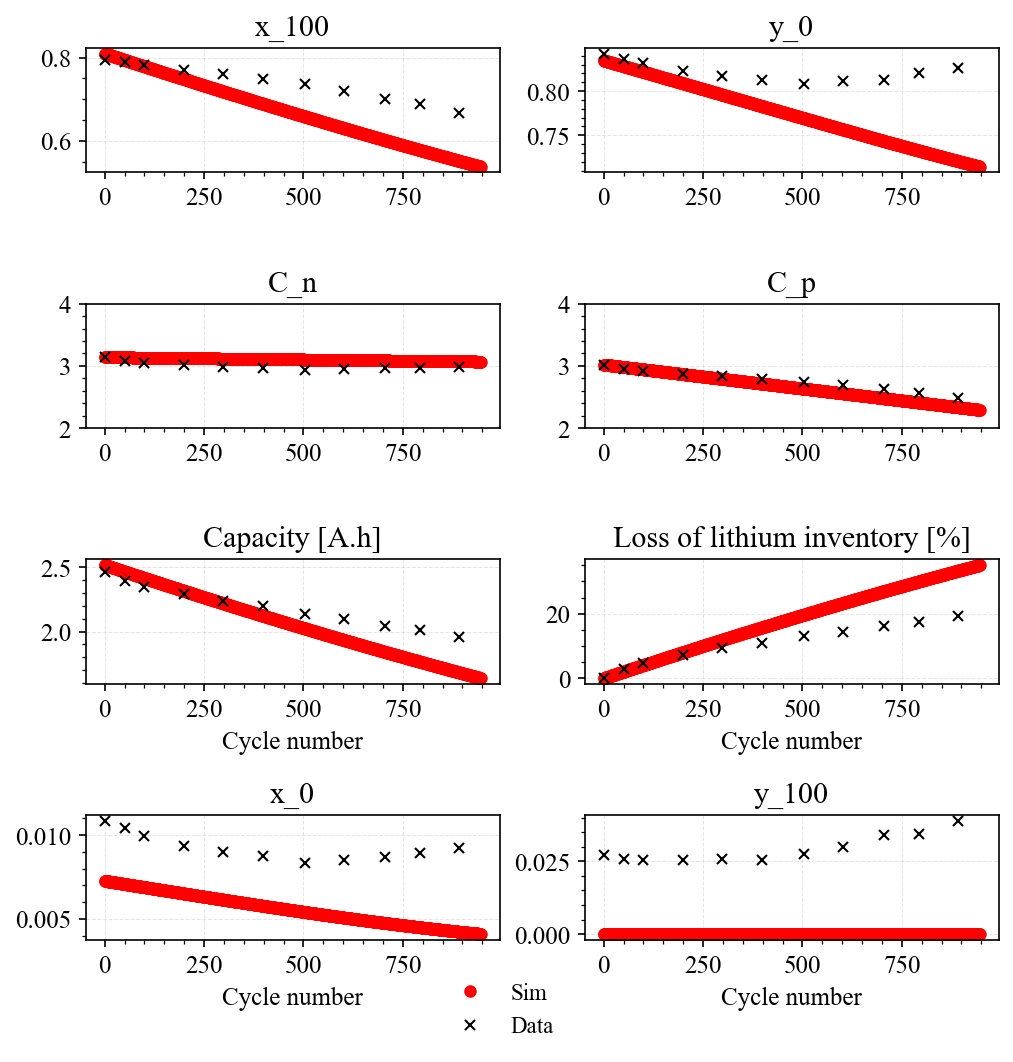

In [11]:
fig = plotc(all_sumvars_dict234,dfe);


In [12]:
all_sumvars_dict33.keys()

NameError: name 'all_sumvars_dict33' is not defined

In [ ]:
all_sumvars_dict33["solution time"]

In [ ]:
# all_sumvars_dict33["Cycle number"]

In [13]:
all_sumvars_dict=all_sumvars_dict234
x100=all_sumvars_dict["x_100"]
y100=all_sumvars_dict["y_100"]
x0=all_sumvars_dict["x_0"]
y0=all_sumvars_dict["y_0"]
Cap=all_sumvars_dict["Capacity [A.h]"]
LoC_SEI_summ=all_sumvars_dict["Loss of capacity to SEI [A.h]"]
LAM_P=all_sumvars_dict["Loss of active material in positive electrode [%]"]
LAM_N=all_sumvars_dict["Loss of active material in negative electrode [%]"]
C_Neg=all_sumvars_dict["C_n"]
C_pos=all_sumvars_dict["C_p"]
LLI=all_sumvars_dict["Loss of lithium inventory [%]"]
LLI_mol= all_sumvars_dict["Total lithium lost [mol]"]
LLI_Side_mol= all_sumvars_dict["Total lithium lost to side reactions [mol]"]
LLI_plating_mol= all_sumvars_dict["Loss of lithium to lithium plating [mol]"]
LLI_SEI_mol= all_sumvars_dict["Loss of lithium to SEI [mol]"]
cycle_num=all_sumvars_dict["Cycle number"]


In [14]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "LLI_mol":LLI_mol,
        "LLI_Side_mol":LLI_Side_mol
    
       }
savemat("Andrew152002__fastsim_experiment234_Dissolution_Aug03.mat",mdic)

In [ ]:
# pybamm.set_logging_level("NOTICE")

# sim_long13 = pybamm.Simulation(spm, experiment=experiment13, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long13 = sim_long13.solve(initial_soc=1, save_at_cycles=1  )


sim_long34 = pybamm.Simulation(spm, experiment=experiment34, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long34 = sim_long34.solve(initial_soc=1, save_at_cycles=1  )


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Positive electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")

ax.set_title("Positive electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("y")
ax = axes.flat[1]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Negative electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")

ax.set_title("Negative electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("x")

In [ ]:
sol_long13.summary_variables.search("electrode")

In [ ]:
sim_long34.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
        "Positive particle surface concentration [mol.m-3]",
        "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Total lithium [mol]",
        "Total lithium in electrolyte [mol]",
        "Total lithium in negative electrode [mol]",
        "Total lithium in particles [mol]",
        "Total lithium in positive electrode [mol]",
        "Total lithium lost [mol]",
        "Total lithium lost from electrolyte [mol]",
        "Total lithium lost from particles [mol]",
        "Total lithium lost to side reactions [mol]",
        "Loss of lithium to lithium plating [mol]",
        "Loss of lithium to SEI [mol]",

    ]
)

In [ ]:
# pybamm.plot_summary_variables(sol_long)

In [ ]:
gnffjj

In [ ]:
sol_long=sol_long34

In [ ]:
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]


LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
LLI_mol= sol_long.summary_variables["Total lithium lost [mol]"]
LLI_Side_mol= sol_long.summary_variables["Total lithium lost to side reactions [mol]"]
LLI_plating_mol= sol_long.summary_variables["Loss of lithium to lithium plating [mol]"]
LLI_SEI_mol= sol_long.summary_variables["Loss of lithium to SEI [mol]"]


cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

# LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
# LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,









In [ ]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "LLI_mol":LLI_mol,
        "LLI_Side_mol":LLI_Side_mol
    
       }
savemat("Andrew152002__experiment233_Dissolution_Aug03.mat",mdic)

In [ ]:
spm.variables.search("Lithium")